# Backtest VWAP performance

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import math
from best_model_selection import get_best_bgm_aic_bic, get_best_ghmm_aic_bic, get_best_gmm_aic_bic

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from hmmlearn.hmm import GaussianHMM, GMMHMM, MultinomialHMM

from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## GLOBAL VARS
## GLOBAL VARS
R_DF_COL_NAMES = ['mean_static', 'sd_static', 
                  'mean_dynamic', 'sd_dynamic',
                  'mean_static_gmm', 'sd_static_gmm', 
                  'mean_dynamic_gmm', 'sd_dynamic_gmm', 
                  'mean_static_bgm', 'sd_static_bgm', 
                  'mean_dynamic_bgm', 'sd_dynamic_bgm', 
                  'mean_static_ghmm', 'sd_static_ghmm', 
                  'mean_dynamic_ghmm', 'sd_dynamic_ghmm', 
                  'from_year']
DATE_TIME = 'date_time'
DATE = 'date'
TIME = 'time'
OPEN_PRICE = 'open'
HIGH_PRICE = 'high'
LOW_PRICE = 'low'
CLOSE_PRICE = 'close'
VOLUME = 'volume'
TURNOVER = 'turnover'
VWAP = 'vwap'
FEATURES = ['high_low_spread', "open_close_rets", "log_total_traded_vol", "daily_log_return", "short_term_vol", "long_term_vol", "money_flow_index"]

## Functions

In [3]:
def load_data(file):
    filepath = os.path.join(DATAPATH, file)
    df = pd.read_csv("file:///" + filepath, parse_dates=[['<DTYYYYMMDD>', '<TIME>']])

    return df

def format_data(df):
    returned_df = df.copy()
    returned_df.drop(labels=["<PER>", "<OPENINT>"], axis="columns", inplace=True)
    returned_df.columns = ['date_time', 'ticker', 'open', 'high', 'low', 'close', 'volume']
    returned_df.set_index('date_time', drop=True, inplace=True)
    returned_df = add_datetime(returned_df)

    return returned_df

def get_open_close_time(df):
    open_time = df.time.min()
    close_time = df.time.max()
    
    return open_time, close_time

def get_open_close_auction_time(df):
    open_time = df.time.min()
    auction_time = df.time.max()
    close_time = df[df[TIME] != df.time.max()].time.max()
    
    return open_time, close_time, auction_time

def get_intraday_data(df, start_time, end_time):
    df = df.between_time(open_time, end_time)
    df[TURNOVER] = df[VOLUME]*df[CLOSE_PRICE]
    df_resampled = df.resample('5T').agg({OPEN_PRICE: "first", 
                                          LOW_PRICE: "min", 
                                          HIGH_PRICE: "max", 
                                          CLOSE_PRICE: "last", 
                                          VOLUME: "sum", 
                                          TURNOVER: "sum"})
    df_resampled[VWAP] = df_resampled[TURNOVER]/df_resampled[VOLUME]
    df_resampled = df_resampled[(df_resampled.index.weekday != 5) | (df_resampled.index.weekday != 6)]
#     open_resampled = df_resampled.index.time.min()
#     close_resmapled = df_resampled.index.time.max()
    
#     print(open_resampled)
#     print(close_resampled)
    
#     df_resampled = df_resampled.between_time(open_resampled, close_resampled)
#     df_resampled.fillna(method='ffill', inplace=True)
    df_resampled.dropna(inplace=True)

    return df_resampled

def get_daily_data(df):
    daily_data = df.groupby(df.index.date).agg({OPEN_PRICE: "first", 
                                                LOW_PRICE: "min",
                                                HIGH_PRICE: "max", 
                                                CLOSE_PRICE: "last", 
                                                VOLUME: "sum", 
                                                TURNOVER: "sum"})
    daily_data[VWAP] = daily_data.turnover/daily_data.volume
    daily_data = daily_data[daily_data[VOLUME] > 0.1]
    daily_data = daily_data[(daily_data.index != 6) & (daily_data.index != 7)]
    daily_data.index = pd.to_datetime(daily_data.index)
    daily_data = daily_data.resample('B').first()
    daily_data.dropna(inplace=True)
    
    
    return daily_data

def split_train_test_data(df, size_in_years):
    training_data = df[df.index[0]:df.index[-1] - relativedelta(years=size_in_years, hours=-9, minutes = -5)]
    test_data = df[df.index[-1] - relativedelta(years=size_in_years, hours=-9):]

    return training_data, test_data

def get_weekdays_data_dict(df):
    weekdays_data_dict = {}
    weekdays_data_dict[0] = df[df.index.weekday == 0]
    weekdays_data_dict[1] = df[df.index.weekday == 1]
    weekdays_data_dict[2] = df[df.index.weekday == 2]
    weekdays_data_dict[3] = df[df.index.weekday == 3]
    weekdays_data_dict[4] = df[df.index.weekday == 4]
    weekdays_data_dict['else'] = df

    return weekdays_data_dict

def get_static_vol_predictor_by_weekday(data, weekdays_data_dict):
    static_vol_predictor = {}
    static_vol_predictor[0] = get_norm_static_vol_predictor(weekdays_data_dict.get(0))
    static_vol_predictor[1] = get_norm_static_vol_predictor(weekdays_data_dict.get(1))
    static_vol_predictor[2] = get_norm_static_vol_predictor(weekdays_data_dict.get(2))
    static_vol_predictor[3] = get_norm_static_vol_predictor(weekdays_data_dict.get(3))
    static_vol_predictor[4] = get_norm_static_vol_predictor(weekdays_data_dict.get(4))
    static_vol_predictor['else'] = get_norm_static_vol_predictor(data)

    return static_vol_predictor

def get_adv_median_by_weekday(data, weekdays_data_dict):
    adv_median = {}
    adv_median[0] = get_adv_median(weekdays_data_dict.get(0))
    adv_median[1] = get_adv_median(weekdays_data_dict.get(1))
    adv_median[2] = get_adv_median(weekdays_data_dict.get(2))
    adv_median[3] = get_adv_median(weekdays_data_dict.get(3))
    adv_median[4] = get_adv_median(weekdays_data_dict.get(4))
    adv_median['else'] = get_adv_median(data)

    return adv_median
  
def get_data_by_weekday(df, weekday):
    df_weekday = df[df.index.weekday == weekday]

    return df_weekday

def add_datetime(df):
    returned_df = df.copy()
    returned_df['date'] = pd.to_datetime(returned_df.index.date)
    returned_df['time'] = pd.to_datetime(returned_df.index, format = "%m-%d-%Y %H:%M:%S")
    returned_df['time'] = returned_df['time'].apply(lambda x: x.strftime('%H:%M:%S'))

    return returned_df

def get_norm_static_vol_predictor(df):
    static_volume_predictor = df.groupby(by=df.index.time)[VOLUME].median()
    norm_static_volume_predictor = static_volume_predictor/sum(static_volume_predictor)

    return norm_static_volume_predictor

def get_reversed_cum_vol(data):
    reversed_cumvol = []
    for day in np.unique(data.index.date):
        reversed_cumvol.append(data[data.index.date == day][VOLUME].cumsum().values[::-1])

    reversed_cumvol = pd.Series(data = np.concatenate(reversed_cumvol), index = data.index)

    return reversed_cumvol

def get_adv_median(df):
    return df['volume'].groupby(df.index.date).sum().median()

def get_adv_mean(df):
    return df['volume'].groupby(df.index.date).sum().median()

def get_daily_VWAP(df):
    return df[TURNOVER].groupby(df.index.date).sum()/df[VOLUME].groupby(df.index.date).sum()
  
def get_vol_predictor_next_bin(data, static_vol_predictor, adv_median):
    volume_predictor_next_interval = data.groupby(data.index.date)[VOLUME].shift(1)
    volume_predictor_next_interval.fillna(int (adv_median.get('else')*static_vol_predictor.get('else').iloc[0]), inplace=True)

    return volume_predictor_next_interval
  
def vwap_static_execution_algo(data, norm_static_vol_predictor, amount_shares, order_side, start_time, end_time, day):
    if day.weekday() == 0:
        vol_predictor = norm_static_vol_predictor.get(0)[start_time:end_time]
    elif day.weekday() == 1:
        vol_predictor = norm_static_vol_predictor.get(1)[start_time:end_time]
    elif day.weekday() == 2:
        vol_predictor = norm_static_vol_predictor.get(2)[start_time:end_time]
    elif day.weekday() == 3:
        vol_predictor = norm_static_vol_predictor.get(3)[start_time:end_time]
    elif day.weekday() == 4:
        vol_predictor = norm_static_vol_predictor.get(4)[start_time:end_time]
    else:
        vol_predictor = norm_static_vol_predictor.get('else')[start_time:end_time]
        
    shares_per_interval = vol_predictor*amount_shares
    
    data['time'] = data.index.time
    data = data.reset_index()
    data = data.set_index(data.time)
    exec_price = (data[HIGH_PRICE]+data[LOW_PRICE])/2
    
    vwap_this_exec_this_day = sum(shares_per_interval*exec_price)/sum(shares_per_interval)
#     vwap_this_exec_this_day = sum(shares_per_interval*data[VWAP])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def vwap_dynamic_execution_algo(data, reversed_cumvol, static_vol_predictor, volume_predictor_next_interval, amount_shares, order_side, start_time, end_time, day):
    shares_per_interval = []
    if day.weekday() == 0:
        shares_per_interval.append(static_vol_predictor.get(0).iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol[reversed_cumvol.index.weekday == 0].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 0].index.time).median()
    elif day.weekday() == 1:
        shares_per_interval.append(static_vol_predictor.get(1).iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol[reversed_cumvol.index.weekday == 1].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 1].index.time).median()
    elif day.weekday() == 2:
        shares_per_interval.append(static_vol_predictor.get(2).iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol[reversed_cumvol.index.weekday == 2].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 2].index.time).median()
    elif day.weekday() == 3:
        shares_per_interval.append(static_vol_predictor.get(3).iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol[reversed_cumvol.index.weekday == 3].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 3].index.time).median()
    elif day.weekday() == 4:
        shares_per_interval.append(static_vol_predictor.get(4).iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol[reversed_cumvol.index.weekday == 4].groupby(reversed_cumvol[reversed_cumvol.index.weekday == 4].index.time).median()
    else:
        shares_per_interval.append(static_vol_predictor.get('else').iloc[0]*amount_shares)
        vol_predictor = reversed_cumvol.groupby(reversed_cumvol.index.time).median()

    for i in range(1, len(data)):
        num = data[VOLUME].iloc[:i].sum()+volume_predictor_next_interval[volume_predictor_next_interval.index.date == day].iloc[i]
        denom = data[VOLUME].iloc[:i].sum()+vol_predictor[i]
        op = amount_shares*(num/denom)
        shares_next_interval = op - sum(shares_per_interval)
        #     shares_next_interval = (amount_shares*((data['volume'].iloc[0:i].sum()+volume_predictor_next_interval.xs(day, level='Date').iloc[i])/(data['volume'].iloc[0:i].sum()+volPredictor[i])))-sum(shares_per_interval)
        shares_per_interval.append(shares_next_interval)

    exec_price = (data[HIGH_PRICE]+data[LOW_PRICE])/2
    
    vwap_this_exec_this_day = sum(shares_per_interval*exec_price)/sum(shares_per_interval)
#     vwap_this_exec_this_day = sum(shares_per_interval*data[VWAP])/sum(shares_per_interval)

    return vwap_this_exec_this_day

def backtest_algo_static(training_data, test_data, adv_median, norm_static_vol_predictor):
    
    backtest_sell_vwap = []
    backtest_buy_vwap = []

    for day in np.unique(test_data.index.date):
        data = test_data[test_data.index.date == day]

        if day.weekday() == 0:
            amount_shares = adv_median.get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = adv_median.get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = adv_median.get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = adv_median.get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = adv_median.get(4)*0.1
        else:
            amount_shares = adv_median.get('else')*0.1
            
        sell_exec = vwap_static_execution_algo(data, norm_static_vol_predictor, amount_shares, 'sell', data.index[0].time(), data.index[-1].time(), day)
        buy_exec = vwap_static_execution_algo(data, norm_static_vol_predictor, amount_shares, 'buy', data.index[0].time(), data.index[-1].time(), day)
        
        backtest_sell_vwap.append(sell_exec)
        backtest_buy_vwap.append(buy_exec)

    return backtest_buy_vwap, backtest_sell_vwap

def backtest_algo_dynamic(train_data, test_data, adv_median, static_vol_predictor):
    reversed_cum_vol = get_reversed_cum_vol(train_data)
    vol_predictor_next_bin = get_vol_predictor_next_bin(test_data, static_vol_predictor, adv_median)

    backtest_sell_vwap_dynamic = []
    backtest_buy_vwap_dynamic = []
    for day in np.unique(test_data.index.date):
        data = test_data[test_data.index.date == day]
        if day.weekday() == 0:
            amount_shares = adv_median.get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = adv_median.get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = adv_median.get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = adv_median.get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = adv_median.get(4)*0.1
        else:
            amount_shares = adv_median.get('else')*0.1
            
        backtest_sell_vwap_dynamic.append(vwap_dynamic_execution_algo(data, 
                                                                      reversed_cum_vol,
                                                                      static_vol_predictor,
                                                                      vol_predictor_next_bin,
                                                                      amount_shares,
                                                                      'sell', 
                                                                      data.index[0].time(),
                                                                      data.index[-1].time(),
                                                                      day))
        backtest_buy_vwap_dynamic.append(vwap_dynamic_execution_algo(data, 
                                                                     reversed_cum_vol,
                                                                     static_vol_predictor,
                                                                     vol_predictor_next_bin,
                                                                     amount_shares,
                                                                     'buy',
                                                                     data.index[0].time(),
                                                                     data.index[-1].time(),
                                                                     day))

    return backtest_buy_vwap_dynamic, backtest_sell_vwap_dynamic
  
def get_algo_performance(train_intraday_data, test_intraday_data, train_daily_data, test_daily_data, dynamic_flag):
    daily_vwap = test_daily_data[VWAP]
    weekdays_data_dict = get_weekdays_data_dict(train_intraday_data)
    static_vol_predictor = get_static_vol_predictor_by_weekday(train_intraday_data, weekdays_data_dict)
    adv_median = get_adv_median_by_weekday(train_intraday_data, weekdays_data_dict)

    if dynamic_flag:
        backtest_buy_vwap, backtest_sell_vwap = backtest_algo_dynamic(train_intraday_data, test_intraday_data, adv_median, static_vol_predictor)
    else:
        backtest_buy_vwap, backtest_sell_vwap = backtest_algo_static(train_intraday_data, test_intraday_data, adv_median, static_vol_predictor)

    static_vwap_comparison = pd.DataFrame(data=daily_vwap.values.tolist(), index=daily_vwap.index, columns=['market_vwap'])
    static_vwap_comparison['backtest_buy_vwap'] = backtest_buy_vwap
    static_vwap_comparison['backtest_sell_vwap'] = backtest_sell_vwap

    static_vwap_comparison['diff_vwap_bps_buy'] = 1e4*(static_vwap_comparison['backtest_buy_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']
    static_vwap_comparison['diff_vwap_bps_sell'] = -1e4*(static_vwap_comparison['backtest_sell_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']

    mean_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].mean()
    sd_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].std()
    mean_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].mean()
    sd_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].std()

    percentiles_diff_vwap_sells = {'1': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.99)}
    percentiles_diff_vwap_buys = {'1': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.99)}

    return mean_bps_diff_buys, sd_bps_diff_buys, static_vwap_comparison['diff_vwap_bps_buy']

def backtest_algo_static_by_regime(training_data, test_data, adv_median, static_vol_predictor):
    backtest_sell_vwap = []
    backtest_buy_vwap = []

    for day in np.unique(test_data.index.date):
        data = test_data[test_data.index.date == day]
        regime = data['regime'].iloc[0]
        
        if day.weekday() == 0:
            amount_shares = adv_median.get(regime).get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = adv_median.get(regime).get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = adv_median.get(regime).get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = adv_median.get(regime).get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = adv_median.get(regime).get(4)*0.1
        else:
            amount_shares = adv_median.get(regime).get('else')*0.1
            
        sell_exec = vwap_static_execution_algo(data,
                                               static_vol_predictor.get(regime),
                                               amount_shares, 'sell',
                                               data.index[0].time(),
                                               data.index[-1].time(), 
                                               day)
        buy_exec = vwap_static_execution_algo(data,
                                              static_vol_predictor.get(regime), 
                                              amount_shares,
                                              'buy',
                                              data.index[0].time(), 
                                              data.index[-1].time(),
                                              day)
        
        backtest_sell_vwap.append(sell_exec)
        backtest_buy_vwap.append(buy_exec)

    return backtest_buy_vwap, backtest_sell_vwap

def backtest_algo_dynamic_by_regime(training_data, test_data, adv_median, static_vol_predictor, regimes):
    regime_reversed_cum_vol = {}
    regime_vol_predictor_next_bin = {}
    for regime in regimes:
        regime_reversed_cum_vol[regime] = get_reversed_cum_vol(training_data[training_data['regime']==regime])
        regime_vol_predictor_next_bin[regime] = get_vol_predictor_next_bin(test_data[test_data['regime']==regime], 
                                                                           static_vol_predictor.get(regime),
                                                                           adv_median.get(regime))

    backtest_sell_vwap_dynamic = []
    backtest_buy_vwap_dynamic = []
    for day in np.unique(test_data.index.date):
        data = test_data[test_data.index.date == day]
        regime = data['regime'].iloc[0]
        if day.weekday() == 0:
            amount_shares = adv_median.get(regime).get(0)*0.1
        elif day.weekday() == 1:
            amount_shares = adv_median.get(regime).get(1)*0.1
        elif day.weekday() == 2:
            amount_shares = adv_median.get(regime).get(2)*0.1
        elif day.weekday() == 3:
            amount_shares = adv_median.get(regime).get(3)*0.1
        elif day.weekday() == 4:
            amount_shares = adv_median.get(regime).get(4)*0.1
        else:
            amount_shares = adv_median.get(regime).get('else')*0.1
        
        backtest_sell_vwap_dynamic.append(vwap_dynamic_execution_algo(data, 
                                                                      regime_reversed_cum_vol.get(regime),
                                                                      static_vol_predictor.get(regime),
                                                                      regime_vol_predictor_next_bin.get(regime),
                                                                      amount_shares,
                                                                      'sell', 
                                                                      data.index[0].time(),
                                                                      data.index[-1].time(),
                                                                      day))
        backtest_buy_vwap_dynamic.append(vwap_dynamic_execution_algo(data, 
                                                                     regime_reversed_cum_vol.get(regime),
                                                                     static_vol_predictor.get(regime),
                                                                     regime_vol_predictor_next_bin.get(regime),
                                                                     amount_shares,
                                                                     'buy',
                                                                     data.index[0].time(),
                                                                     data.index[-1].time(),
                                                                     day))
            
        

    return backtest_buy_vwap_dynamic, backtest_sell_vwap_dynamic

def get_algo_performance_by_regime(training_data, test_data, vwap_and_regime, dynamic_flag, regimes):
    regime_daily_vwap = {}
    regime_weekdays_data_dict = {}
    regime_static_vol_predictor = {}
    regime_adv_median = {}
    daily_vwap = vwap_and_regime[VWAP]
    for regime in regimes:
        regime_daily_vwap[regime] = vwap_and_regime[vwap_and_regime['regime'] == regime][VWAP]
        regime_weekdays_data_dict[regime] = get_weekdays_data_dict(training_data[training_data['regime'] == regime])
        regime_static_vol_predictor[regime] = get_static_vol_predictor_by_weekday(training_data[training_data['regime'] == regime],
                                                                                  regime_weekdays_data_dict[regime])
        regime_adv_median[regime] = get_adv_median_by_weekday(training_data[training_data['regime'] == regime], 
                                                              regime_weekdays_data_dict[regime])

    if dynamic_flag:
        backtest_buy_vwap, backtest_sell_vwap = backtest_algo_dynamic_by_regime(training_data, 
                                                                                test_data,
                                                                                regime_adv_median,
                                                                                regime_static_vol_predictor,
                                                                                regimes)
    else:
        backtest_buy_vwap, backtest_sell_vwap = backtest_algo_static_by_regime(training_data,
                                                                               test_data,
                                                                               regime_adv_median,
                                                                               regime_static_vol_predictor)

    static_vwap_comparison = pd.DataFrame(data=daily_vwap.values.tolist(), index=daily_vwap.index, columns=['market_vwap'])
    static_vwap_comparison['backtest_buy_vwap'] = backtest_buy_vwap
    static_vwap_comparison['backtest_sell_vwap'] = backtest_sell_vwap

    static_vwap_comparison['diff_vwap_bps_buy'] = 1e4*(static_vwap_comparison['backtest_buy_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']
    static_vwap_comparison['diff_vwap_bps_sell'] = -1e4*(static_vwap_comparison['backtest_sell_vwap']-static_vwap_comparison['market_vwap'])/static_vwap_comparison['market_vwap']

    mean_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].mean()
    sd_bps_diff_buys = static_vwap_comparison['diff_vwap_bps_buy'].std()
    mean_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].mean()
    sd_bps_diff_sells = static_vwap_comparison['diff_vwap_bps_sell'].std()

    percentiles_diff_vwap_sells = {'1': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_sell'].quantile(0.99)}
    percentiles_diff_vwap_buys = {'1': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.01),
                               '5': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.05),
                               '95': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.95),
                               '99': static_vwap_comparison['diff_vwap_bps_buy'].quantile(0.99)}
    
    return mean_bps_diff_buys, sd_bps_diff_buys, static_vwap_comparison['diff_vwap_bps_buy']

def get_log_total_trade_vol(df):
    log_total_traded_vol = get_log(get_total_traded_vol(df))
    log_total_traded_vol.name = "log_total_traded_vol"
    
    return log_total_traded_vol 

def get_total_traded_vol(df):
    total_traded_vol = df.resample('B').first()[[VOLUME]]
    total_traded_vol.name = "total_traded_vol"

    return total_traded_vol

def get_log_open_close_returns(df):
    open_close_returns = np.log(df[OPEN_PRICE]/df[CLOSE_PRICE].shift(-1)).dropna()
    open_close_returns.name = "log_overnight_returns"

    return open_close_returns

def get_log_returns(df):
    close = df[CLOSE_PRICE].resample('B').last()
    log_daily_returns = np.log(close/close.shift(-1))
    log_daily_returns.name = "log_returns"

    return log_daily_returns

def get_high_low_spread(df):
    high_low_spread = (df[HIGH_PRICE]-df[LOW_PRICE])
    high_low_spread.name = "high_low_spread"

    return high_low_spread

def get_log(df):
    return np.log(df)

def get_antilog_adv_median(df):
    antilog_adv = np.exp(get_log(daily_data[VOLUME]).rolling(20, min_periods=5).median().dropna())
    antilog_adv.name = "antilog_adv"
    
    return antilog_adv

def get_money_flow_index(df):
    typical_price = (df[CLOSE_PRICE]+df[HIGH_PRICE]+df[LOW_PRICE])/3
    volume = df[VOLUME]
    money_flow_index = typical_price*volume
    money_flow_index.name = "money_flow_index"

    return money_flow_index

def get_beta_market_impact(df):
    adv_antilog = get_antilog_adv_median(df)
    X = df[VOLUME]/adv_antilog
    Y = ((df[VWAP]-df[OPEN_PRICE])/df[OPEN_PRICE])*1e4
    betas = Y/X
    betas.name = "betas_market_impact"
    
    return betas

def get_features_df(list_of_features):
    features_df = pd.concat(list_of_features, axis=1).dropna()
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.dropna()
    features_df = features_df[features_df != 0.0].shift(1).dropna()
#     features_df.rename(columns={VOLUME: "log_total_traded_vol"}, inplace=True)

    return features_df

def fit_model(model, full_data, train_data, list_of_features):
    X = train_data.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    if len(list_of_features) > 2:
        pca = PCA(n_components=.95)
        pca.fit(X_scaled)
        X_pca = pca.transform(X_scaled)
        fitted_model = model.fit(X_pca)
        X_full = full_data.values
        X_full_scaled = scaler.transform(X_full)
        X_full_pca = pca.transform(X_full_scaled)
        prediction = fitted_model.predict(X_full_pca)
    else:
        fitted_model = model.fit(X_scaled)
        X_full = full_data.values
        X_full_scaled = scaler.transform(X_full)
        prediction = fitted_model.predict(X_full_scaled)

    return prediction

def get_features_series_list(daily_data):
    log_returns = get_log_returns(daily_data)
    adv_antilog = get_antilog_adv_median(daily_data)
    mfi = get_money_flow_index(daily_data)
    betas_mkt_impact = get_beta_market_impact(daily_data)
    log_traded_vol = get_log_total_trade_vol(daily_data)
    
    features = [log_returns, adv_antilog, mfi, betas_mkt_impact, log_traded_vol]
    
    return features

In [4]:
def get_results_df(ticker, list_of_results):
    arr = np.array(list_of_results).reshape(1,17)
    columns_names = R_DF_COL_NAMES
    r_df = pd.DataFrame(data=arr, columns=columns_names, index=[ticker])
    
    return r_df

def get_full_algo_performance(daily_data, intraday_data, current_ticker, from_year = 1900):
    results_list = []
    year_from = daily_data.index[0].year
    diff_bps_dict = {}
    
    train_daily_data, test_daily_data = split_train_test_data(daily_data, 2)
    train_intraday_data, test_intraday_data = split_train_test_data(intraday_data, 2)

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance(train_intraday_data, test_intraday_data, train_daily_data, test_daily_data, dynamic_flag=False)
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['static'] = diff_bps

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance(train_intraday_data, test_intraday_data, train_daily_data, test_daily_data, dynamic_flag=True)
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['dynamic'] = diff_bps

    features_list = get_features_series_list(daily_data)
    features_df = get_features_df(features_list)

    best_gmm, features_gmm, results_gmm_df = get_best_gmm_aic_bic(features_list, pca_flag=False)
    best_bgm, features_bgm, results_bgm_df = get_best_bgm_aic_bic(features_list, pca_flag=False)
    best_ghmm, features_ghmm, results_ghmm_df= get_best_ghmm_aic_bic(features_list, pca_flag=False)

    train_features_df, test_features_df = split_train_test_data(features_df[features_gmm], 2)

    model_prediction = fit_model(best_gmm, features_df[features_gmm], train_features_df, features_gmm)
    regime = pd.Series(data = model_prediction, index = features_df.index).rename("regime")

    intraday_date = intraday_data.copy()
    intraday_date['date'] = pd.to_datetime(intraday_date.index.date)
    regime_intraday = pd.merge(intraday_date, regime, right_index=True, how='left', left_on='date').dropna()
    regime_intraday = regime_intraday.astype({"regime":"int32"})

    regime_daily = pd.merge(daily_data, regime, left_index=True, right_index=True)
    regime_daily = regime_daily.astype({"regime":"int32"})

    intraday_regime_train, intraday_regime_test = split_train_test_data(regime_intraday, 2)
    daily_regime_train, daily_regime_test = split_train_test_data(regime_daily, 2)

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=False, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['static_gmm'] = diff_bps

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=True, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['dynamic_gmm'] = diff_bps
    
    train_features_df, test_features_df = split_train_test_data(features_df[features_bgm], 2)
    
    model_prediction = fit_model(best_bgm, features_df[features_bgm], train_features_df, features_bgm)
    regime = pd.Series(data = model_prediction, index = features_df.index).rename("regime")
    regime = regime.resample("5T").asfreq().fillna(method="ffill")

    regime_intraday = pd.merge(intraday_date, regime, right_index=True, how='left', left_on='date').dropna()
    regime_intraday = regime_intraday.astype({"regime":"int32"})

    regime_daily = pd.merge(daily_data, regime, left_index=True, right_index=True)
    regime_daily = regime_daily.astype({"regime":"int32"})

    intraday_regime_train, intraday_regime_test = split_train_test_data(regime_intraday, 2)
    daily_regime_train, daily_regime_test = split_train_test_data(regime_daily, 2)

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=False, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['static_bgm'] = diff_bps

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=True, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['dynamic_bgm'] = diff_bps
    
    train_features_df, test_features_df = split_train_test_data(features_df[features_ghmm], 2)
    
    model_prediction = fit_model(best_ghmm, features_df[features_ghmm], train_features_df, features_ghmm)
    regime = pd.Series(data = model_prediction, index = features_df.index).rename("regime")
    regime = regime.resample("5T").asfreq().fillna(method="ffill")

    regime_intraday = pd.merge(intraday_date, regime, right_index=True, how='left', left_on='date').dropna()
    regime_intraday = regime_intraday.astype({"regime":"int32"})

    regime_daily = pd.merge(daily_data, regime, left_index=True, right_index=True)
    regime_daily = regime_daily.astype({"regime":"int32"})

    intraday_regime_train, intraday_regime_test = split_train_test_data(regime_intraday, 2)
    daily_regime_train, daily_regime_test = split_train_test_data(regime_daily, 2)

    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=False, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['static_ghmm'] = diff_bps
    
    mean_bps_diff_buys, sd_bps_diff_buys, diff_bps = get_algo_performance_by_regime(intraday_regime_train, intraday_regime_test, daily_regime_test[[VWAP, "regime"]], dynamic_flag=True, regimes=regime_intraday['regime'].unique())
    results_list.append(np.abs(mean_bps_diff_buys))
    results_list.append(np.abs(sd_bps_diff_buys))
    diff_bps_dict['dynamic_ghmm'] = diff_bps
    results_list.append(from_year)
    
    results_df = get_results_df(current_ticker, results_list)
    
    return results_df, diff_bps_dict

In [5]:
warnings.filterwarnings("ignore")
DATAPATH = os.getcwd()+"\\Data\\"
filepath_anon = os.path.join(DATAPATH, "volume_price_2014_18.csv")

In [6]:
files_list = []
for root, dirs, files in os.walk(DATAPATH):
    for file in files:
        files_list.append(file)

In [7]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, files_list[5]), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = format_data(raw)
df_less_days = df[df.index.year >= 1900]
open_time, close_time, auction_time = get_open_close_auction_time(df_less_days)
intraday_data = get_intraday_data(df_less_days, open_time, close_time)
daily_data = get_daily_data(intraday_data)
current_ticker = df.ticker.iloc[0]

resultado, diff_bps = get_full_algo_performance(daily_data, intraday_data, current_ticker)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -47279.0270393885
Scores obtained -> BIC: -47022.20797010322, AIC: -47535.84610867378, SC: 0.23215516389609628
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -47696.39926542141
Scores obtained -> BIC: -47439.58019613613, AIC: -47953.21833470669, SC: 0.41018341246972956
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200, 'algorithm': 'map'} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -202632728.02935487
Scores obtained -> BIC: -202632471.21028557

In [12]:
raw = pd.read_csv("file:///" + os.path.join(DATAPATH, "TEF.txt"), parse_dates=[['<DTYYYYMMDD>', '<TIME>']])
df = format_data(raw)
df_less_days = df[df.index.year >= 1900]
open_time, close_time, auction_time = get_open_close_auction_time(df_less_days)
intraday_data = get_intraday_data(df_less_days, open_time, close_time)
daily_data = get_daily_data(intraday_data)
current_ticker = df.ticker.iloc[0]

resultado, diff_bps = get_full_algo_performance(daily_data, intraday_data, current_ticker)

Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 200} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -50820.766844671685
Scores obtained -> BIC: -50558.01600954059, AIC: -51083.51767980278, SC: 0.3828172102997777
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 800, 'weight_concentration_prior_type': 'dirichlet_distribution'} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -50945.943608312286
Scores obtained -> BIC: -50683.19277318119, AIC: -51208.69444344338, SC: 0.3828172102997777
Optimal params are {'n_components': 4, 'covariance_type': 'full', 'max_iter': 100, 'algorithm': 'viterbi'} using ['log_returns', 'antilog_adv', 'money_flow_index', 'betas_market_impact', 'volume'] obtaining a Combined BIC-AIC score of -248139946.81226885
Scores obtained -> BIC: -248139684.061

In [13]:
resultado_tef = resultado
diff_bps_tef = diff_bps

In [11]:
resultado_cbk = resultado
diff_bps_cbk = diff_bps

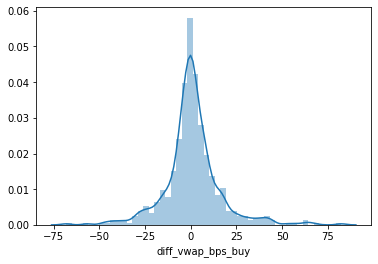

In [52]:
sns.distplot(diff_bps.get('static').dropna())

In [ ]:
figure.set_size_inches(22,12)

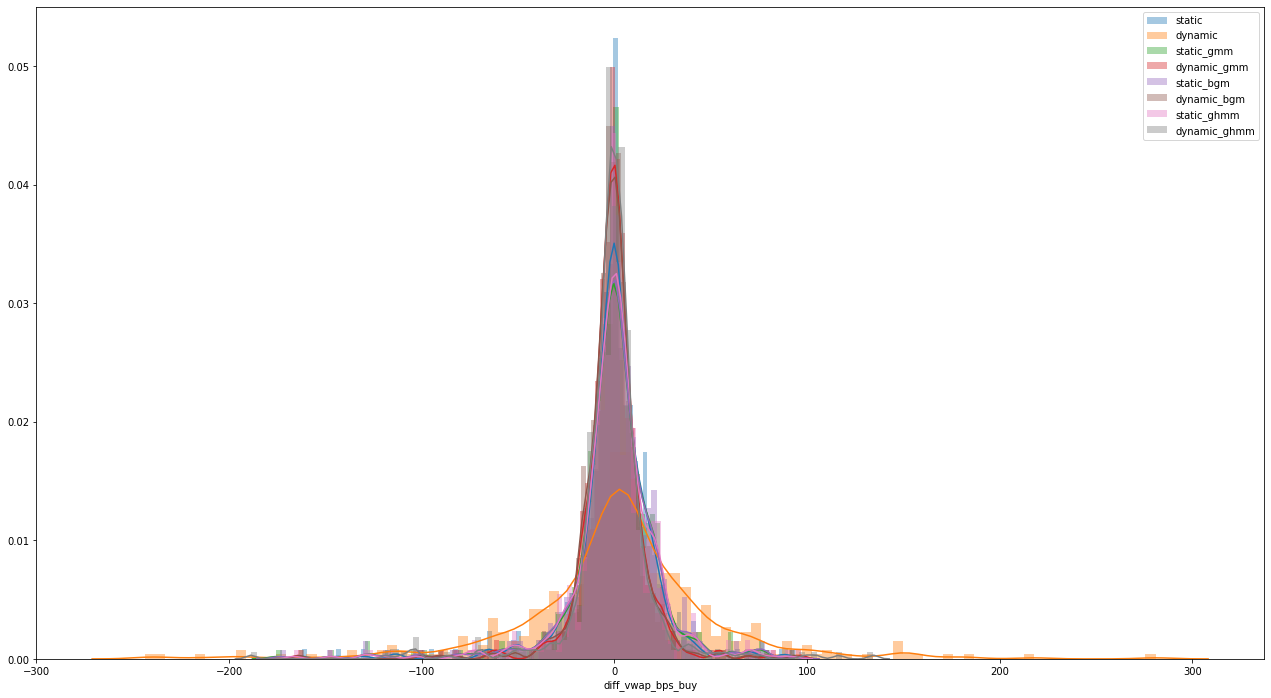

In [8]:
plt.figure(figsize=(22,12))
for k, v in diff_bps.items():
    sns.distplot(v.dropna(), label=k, bins=100)
    plt.legend()

In [ ]:
sns.d

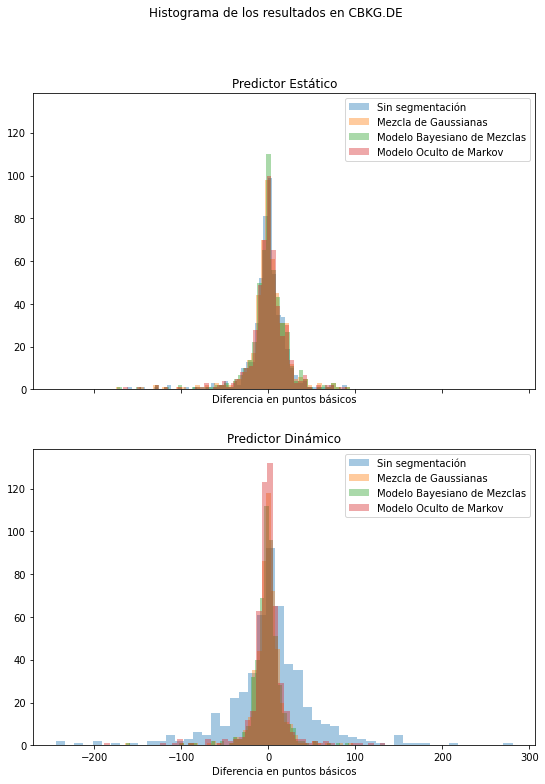

In [23]:
label_dict = {'static': 'Sin segmentación',
              'static_gmm': 'Mezcla de Gaussianas',
              'static_bgm': 'Modelo Bayesiano de Mezclas',
              'static_ghmm': 'Modelo Oculto de Markov', 
              'dynamic': 'Sin segmentación',
              'dynamic_gmm': 'Mezcla de Gaussianas',
              'dynamic_bgm': 'Modelo Bayesiano de Mezclas',
              'dynamic_ghmm': 'Modelo Oculto de Markov'}
figure, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True)
figure.set_size_inches(9,12)
figure.suptitle('Histograma de los resultados en CBKG.DE')
axes[0].set_title('Predictor Estático')
axes[1].set_title('Predictor Dinámico')
for k, v in diff_bps_cbk.items():
    if 'static' in k:
        sns.distplot(v.dropna(), kde=False, label=label_dict.get(k), ax=axes[0], axlabel="Diferencia en puntos básicos")
        axes[0].legend()
    if 'dynamic' in k:
        sns.distplot(v.dropna(), kde=False, label=label_dict.get(k), ax=axes[1], axlabel="Diferencia en puntos básicos")
        axes[1].legend()

plt.legend()
plt.show()